In [28]:
#  Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

#  Import python wrapper for pitch-by-pitch data from MLB APIs
from pybaseball import statcast

In [29]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.linear_model import Lasso, ElasticNet, Ridge

In [30]:
#  Pull all pitches thrown in 2023 season through May 5
pitches = statcast(start_dt='2023-03-01', end_dt='2023-05-05')

This is a large query, it may take a moment to complete


C:\Users\rob\anaconda3\lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [01:06<00:00,  1.27s/it]


In [31]:
import lzma
import pickle

In [32]:
#  View data
pitches.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
3295,SL,2023-05-05,83.1,-2.81,5.97,"Romano, Jordan",609280,605447,field_out,hit_into_play,...,4,4,0,0,4,Strategic,Standard,57,-0.001,-0.097
3404,SL,2023-05-05,84.0,-3.02,5.78,"Romano, Jordan",609280,605447,NaN,called_strike,...,4,4,0,0,4,Strategic,Standard,67,0.0,-0.027
3519,SL,2023-05-05,87.1,-2.98,5.9,"Romano, Jordan",609280,605447,NaN,ball,...,4,4,0,0,4,Strategic,Standard,64,0.0,0.021
3629,FF,2023-05-05,96.9,-2.83,6.02,"Romano, Jordan",669261,605447,strikeout,swinging_strike,...,4,4,0,0,4,Standard,Standard,198,-0.005,-0.123
3702,FF,2023-05-05,94.2,-3.23,5.73,"Romano, Jordan",669261,605447,NaN,swinging_strike,...,4,4,0,0,4,Standard,Standard,208,0.0,-0.043


In [33]:
#  View columns - data dictionary available at https://baseballsavant.mlb.com/csv-docs
pitches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185617 entries, 3295 to 1377
Data columns (total 92 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   pitch_type                       169421 non-null  object        
 1   game_date                        185617 non-null  datetime64[ns]
 2   release_speed                    169405 non-null  Float64       
 3   release_pos_x                    169416 non-null  Float64       
 4   release_pos_z                    169416 non-null  Float64       
 5   player_name                      185617 non-null  object        
 6   batter                           185617 non-null  Int64         
 7   pitcher                          185617 non-null  Int64         
 8   events                           51503 non-null   object        
 9   description                      185617 non-null  object        
 10  spin_dir                         0 non-null

In [34]:
#  View pitch outcome types
pitches['description'].value_counts()

ball                       61292
hit_into_play              34274
called_strike              30595
foul                       30400
swinging_strike            21781
blocked_ball                3613
foul_tip                    1731
swinging_strike_blocked     1028
hit_by_pitch                 608
foul_bunt                    241
missed_bunt                   42
pitchout                       8
bunt_foul_tip                  4
Name: description, dtype: int64

In [35]:
#  View pitch "event" outcomes 
#  Note:  almost all of these are subcategories of pitches['description'] == 'hit_into_play'
pitches['events'].value_counts()

field_out                    19826
strikeout                    11979
single                        7323
walk                          4484
double                        2356
home_run                      1490
force_out                     1022
grounded_into_double_play      981
hit_by_pitch                   608
sac_fly                        351
field_error                    345
triple                         181
double_play                    112
sac_bunt                       105
fielders_choice                 95
fielders_choice_out             76
caught_stealing_2b              66
catcher_interf                  37
strikeout_double_play           35
caught_stealing_home             7
other_out                        6
sac_fly_double_play              6
pickoff_1b                       5
wild_pitch                       3
caught_stealing_3b               3
pickoff_3b                       1
Name: events, dtype: int64

In [36]:
#  View types of games
pitches['game_type'].value_counts()

R    144334
S     41283
Name: game_type, dtype: int64

In [37]:
#  Limit inquiry to regular season games
pitches = pitches[pitches['game_type'] == 'R']

In [38]:
#  Dummify pitching hand (1 for Left-handed, 0 for right-handed)
pitches['p_throws'] = pitches['p_throws'].apply(lambda x: 1 if x == 'L' else 0)

In [39]:
#  Create feature to distinguish between starters and relievers
#  Starting pitchers pitch less frequently, and therefore have longer stamina to remain in a game

##  For more background on the differences between starting and relief pitching, 
##  read descriptions at https://www.mlb.com/glossary/positions/).  

#  Noting exceptions (such as the phenomenon of the "opener" with the Tampa Bay Rays)
#  we assume any pitcher who pitches in the first inning is a starter

starters = set(pitches.loc[pitches['inning'] == 1,'player_name'])  
pitches['starter'] = [1 if player in starters else 0 for player in pitches['player_name']]

In [40]:
#  Create column for number of pitches thrown to that point on that game
pitches['pitch_no'] = pitches.groupby(['player_name','game_date']).cumcount() + 1

In [41]:
#  Create target variables for outcomes: ball, swinging strike, foul, called strike, out in the field, and hit.  
pitches['ball'] = pitches['description'].apply(lambda x: 1 if x == 'ball' 
                                               else 1 if x == 'hit_by_pitch'
                                               else 1 if x == 'blocked_ball'
                                               else 1 if x == 'pitchout'
                                               else 0)

pitches['swing'] = pitches['description'].apply(lambda x: 1 if x == 'swinging_strike'
                                                else 1 if x == 'swinging_strike_blocked'
                                                else 1 if x == 'missed_bunt'
                                                else 1 if x == 'foul_tip'
                                                else 0)

pitches['foul'] = pitches['description'].apply(lambda x: 1 if x == 'foul'
                                               else 1 if x == 'foul_bunt'
                                               else 1 if x == 'bunt_foul_tip'
                                               else 0)

pitches['called'] = pitches['description'].apply(lambda x: 1 if x == 'called_strike' else 0)

pitches['out'] = pitches['events'].apply(lambda x: 1 if x == 'field_out' 
                                         else 1 if x == 'grounded_into_double_play'
                                         else 1 if x == 'force_out'
                                         else 1 if x == 'double_play'
                                         else 1 if x == 'sac_fly_double_play'
                                         else 1 if x == 'fielders_choice_out'
                                         else 1 if x == 'fielders_choice'
                                         else 0)

pitches['hit'] = pitches['events'].apply(lambda x: 1 if x == 'single'
                                         else 1 if x == 'double'
                                         else 1 if x == 'triple'
                                         else 1 if x == 'home_run'
                                         else 1 if x == 'sac_fly'
                                         else 1 if x == 'sac_bunt'
                                         else 1 if x == 'field_error'
                                         else 1 if x == 'catcher_interf'
                                         else 0)

In [ ]:
#  View pitch types
pitches['pitch_type'].value_counts()

In [ ]:
#  View pitch names for reference (each one matches the code in pitch_type)
pitches['pitch_name'].value_counts()

In [ ]:
#  View columns with highest null count
pitches.isnull().sum().sort_values(ascending = False).head(50)

In [18]:
#  Engineer vehicles to emphasize vertical movement (reasons discussed in EDA)
pitches['vz0*2'] = pitches['vz0'] ** 2

In [19]:
pitches['pfx_z*2'] = pitches['pfx_z'] ** 2

In [20]:
pitches['plate_z*2'] = pitches['plate_z'] ** 2

In [21]:
# Drop columns with nulls > 472
##  release_extension has the highest nulls for any of the remaining columns of interest
pitches.dropna(axis = 1, thresh = 144344-472, inplace = True)

#  Drop remaining rows with nulls
pitches.dropna(axis = 0, inplace = True)

#  Check for any remaining nulls
pitches.isnull().sum().sum()

0

In [22]:
#  Define columns of interest (features and target)
pitches = pitches[['vx0', 'vy0', 'vz0',
 'release_speed', 'release_spin_rate','pfx_x', 'pfx_z', 'plate_x', 'plate_z',
 'ax', 'ay', 'az', 'release_pos_x', 'release_pos_y', 'release_pos_z',
 'vz0*2',
 'pfx_z*2',
 'plate_z*2','p_throws','starter',
 'sz_top',
 'sz_bot','pitch_type','player_name','pitch_no',
                  'ball', 'swing','called','foul', 'out','hit']]

In [23]:
#  Compress and store as lzma pickled file
with lzma.open("../data/pitches.xz", "wb") as f:
    pickle.dump(pitches, f)

In [400]:
import pickle
pickle.dump(X_train, open('../data/X_train.pkl', 'wb'))

In [7]:
X_train = pd.read_csv('../data/X_train.csv')

In [8]:
X_test = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [9]:
import lzma

In [11]:
import pickle

In [ ]:
with lzma.open("../data/X_train.xz", "wb") as f:
    pickle.dump(X_train, f)

In [306]:
enet = ElasticNet(alpha = 5, l1_ratio = 0.001)
enet.fit(X_train, y_train)

ElasticNet(alpha=5, l1_ratio=0.001)

In [312]:
train_score = cross_val_score(enet, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 5).mean()

In [314]:
(train_score * -1) ** 0.5

2.274958516205618

In [316]:
test_score = cross_val_score(enet, X_test, y_test, scoring = 'neg_mean_squared_error', cv = 5).mean()

In [317]:
(test_score * -1) ** 0.5

2.289143682670437

In [319]:
X_test.shape

(35953, 623)

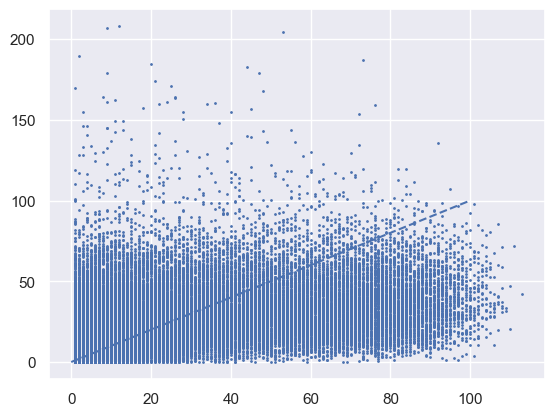

In [329]:
plt.scatter(y = enet.predict(X_test) ** 2, x = y_test ** 2, s = 1)
plt.plot([0,100],[0,100], linestyle = '--')

In [ ]:
import pickle

In [346]:
import pickle
pickle.dump(ss, open('../data/scaler.pkl', 'wb'))

In [348]:
pickle.dump(enet, open('../data/model.pkl', 'wb'))

In [340]:
filename = 'model.sav'

In [337]:
pickle.dump(enet, open('../data/model.sav', 'wb'))

In [338]:
new_model = pickle.load(open('../data/model.sav', 'rb'))

In [339]:
new_model

'model.sav'

In [393]:
#  Dummify pitch type, but keep original for further preprocessing
X['pitch_type_orig'] = X['pitch_type']
X = pd.get_dummies(X, columns = ['pitch_type'])

C:\Users\rob\AppData\Local\Temp\ipykernel_9140\2939201450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['pitch_type_orig'] = X['pitch_type']
